<a href="https://colab.research.google.com/github/RAHULSS23/project/blob/master/covid_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#Dataset : https://www.dropbox.com/sh/1bsr1qshye7w88a/AAAcqo5kdltzxiNIgGu25uBSa?dl=0
!wget https://www.dropbox.com/sh/1bsr1qshye7w88a/AAAcqo5kdltzxiNIgGu25uBSa?dl=0

--2021-02-15 08:59:02--  https://www.dropbox.com/sh/1bsr1qshye7w88a/AAAcqo5kdltzxiNIgGu25uBSa?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.18, 2620:100:6032:18::a27d:5212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/1bsr1qshye7w88a/AAAcqo5kdltzxiNIgGu25uBSa [following]
--2021-02-15 08:59:03--  https://www.dropbox.com/sh/raw/1bsr1qshye7w88a/AAAcqo5kdltzxiNIgGu25uBSa
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc75ee02b52004dd312da0d8d949.dl.dropboxusercontent.com/zip_download_get/AsU3HP1fPjtHijKIKNHMeGp1Clj4FjmdwbnmGFkdUg1uEpu-PtaqkNDH9hItQvlk1smjJloX2TgL1J0LxO1uYa9kInp7TqKdkXuwQLfPnlWWXQ [following]
--2021-02-15 08:59:04--  https://uc75ee02b52004dd312da0d8d949.dl.dropboxusercontent.com/zip_download_get/AsU3HP1fPjtHijKIKNHMeGp1Clj4FjmdwbnmGFkdUg1uEpu-PtaqkNDH9hItQvlk1smjJloX2TgL1J

In [ ]:
!unzip covid

In [ ]:
import tensorflow as tf
import pandas as pd
import random
from imutils import paths
from tensorflow.keras.applications import VGG16, VGG19
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import cv2
import os

In [6]:
#Loading the data about data
covid_data = pd.read_csv('metadata.csv')
covid_data.head()

,Patientid,offset,sex,age,finding,survival,view,modality,date,location,filename,doi,url,license,clinical notes,other notes,Unnamed: 16
0,2,0.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
2,2,5.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
3,2,6.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
4,4,0.0,F,52.0,COVID-19,NaN,PA,X-ray,2020,"Changhua Christian Hospital, Changhua City, Ta...",nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [7]:
covid_data[['finding','view','modality','location']]

,finding,view,modality,location
0,COVID-19,PA,X-ray,NaN
1,COVID-19,PA,X-ray,NaN
2,COVID-19,PA,X-ray,NaN
3,COVID-19,PA,X-ray,NaN
4,COVID-19,PA,X-ray,"Changhua Christian Hospital, Changhua City, Ta..."
...,...,...,...,...
141,COVID-19,AP Supine,X-ray,Italy
142,COVID-19,PA,X-ray,"The Royal Melbourne Hospital, Melbourne, Austr..."
143,COVID-19,PA,X-ray,"The Royal Melbourne Hospital, Melbourne, Austr..."
144,COVID-19,AP,X-ray,NaN


Number of training images:  138


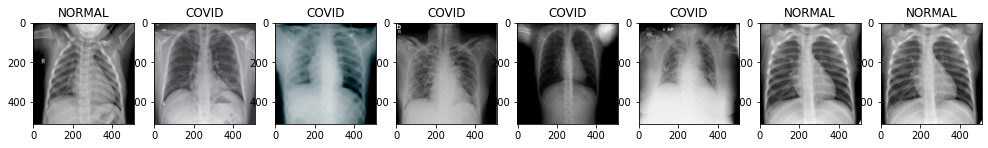

In [10]:
#List of files
path_list = list(paths.list_images('dataset'))
X = []
Y = []


for path in path_list:
    # Set Class label
    y = path.split(os.path.sep)[-2]
    # Grayscale the image and reshape
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (512, 512))

    # update the data and labels lists, respectively
    X.append(image)
    Y.append(y)

# Normalize images
X = np.array(X) / 255.0
Y = np.array(Y)

print('Number of training images: ', len(X))
# Plot example patient scan
W = 8
L = 1
fig, axes = plt.subplots(L, W, figsize = (17,17))
axes = axes.ravel() 
n = 138
for i in np.arange(0, W * L):
    index = np.random.randint(0, n)    
    axes[i].imshow( X[index] )
    axes[i].set_title(Y[index])


#one-hot encoding on the labels
lb = LabelBinarizer()
Y = lb.fit_transform(Y)
Y = tf.keras.utils.to_categorical(Y)

In [12]:

# split training and test data
(X_train, x_test, Y_train, y_test) = train_test_split(X, Y,
	test_size=0.20, stratify=Y, random_state=2019)

(x_train, x_valid, y_train, y_valid) = train_test_split(X_train, Y_train,
	test_size=0.20, stratify=Y_train, random_state=2019)

In [13]:

Datagen= tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,
                            rotation_range=20,width_shift_range=0.2,
                            height_shift_range=0.2,horizontal_flip=True)

In [14]:
def Covid_model():
    input_img = tf.keras.layers.Input(shape=(512, 512, 3))
    baseModel = VGG16(weights="imagenet", include_top=False,
	  input_tensor=tf.keras.layers.Input(shape=(512, 512, 3)))

    # Make all pre-trained layers from VGG19 non-trainable 
    for layer in baseModel.layers[:-3]:
        layer.trainable = False
    x = baseModel.output
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(2, activation='softmax')(x)
  
    
    covid_model = tf.keras.models.Model(baseModel.input, x)
    adagrad=tf.keras.optimizers.Adagrad(lr=0.001)
    covid_model.compile(optimizer=adagrad, loss='binary_crossentropy',metrics=["accuracy"])
    return covid_model

In [18]:
model= Covid_model()
model.summary()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)
covid= model.fit_generator(Datagen.flow(x_train, y_train, batch_size=8),
                      steps_per_epoch=len(x_train) / 8,
                      validation_data=(x_valid, y_valid), epochs=30,callbacks = [early_stopping])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0   

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/30
11/11 [==============================] - 7s 484ms/step - loss: 0.9793 - accuracy: 0.5250 - val_loss: 0.6825 - val_accuracy: 0.5000
Epoch 2/30
11/11 [==============================] - 5s 457ms/step - loss: 0.8512 - accuracy: 0.6405 - val_loss: 0.6805 - val_accuracy: 0.5000
Epoch 3/30
11/11 [==============================] - 5s 454ms/step - loss: 0.6272 - accuracy: 0.7223 - val_loss: 0.6729 - val_accuracy: 0.5000
Epoch 4/30
11/11 [==============================] - 5s 459ms/step - loss: 0.6453 - accuracy: 0.7250 - val_loss: 0.6530 - val_accuracy: 0.5000
Epoch 5/30
11/11 [==============================] - 5s 459ms/step - loss: 0.4698 - accuracy: 0.8680 - val_loss: 0.6440 - val_accuracy: 0.5000
Epoch 6/30
11/11 [==============================] - 5s 467ms/step - loss: 0.4305 - accuracy: 0.8180 - val_loss: 0.6124 - val_accuracy: 0.6818
Epoch 7/30
11/11 [==============================] - 5s 469ms/step - loss: 0.3595 - accuracy: 0.8792 - val_loss: 0.6116 - val_accuracy: 0.7273
Epoch 

loss :  0.5216459631919861
accuracy :  0.9642857313156128
              precision    recall  f1-score   support

       COVID       0.93      1.00      0.96        13
      NORMAL       1.00      0.93      0.97        15

    accuracy                           0.96        28
   macro avg       0.96      0.97      0.96        28
weighted avg       0.97      0.96      0.96        28

accuracy: 0.9643
sensitivity: 1.0000
specificity: 0.9333


Text(0.5, 15.0, 'Predicted label')

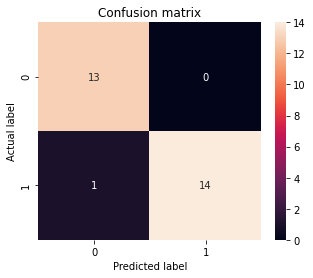

In [19]:
y_pred = model.predict(x_test, batch_size=8)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


predicted_metrics = model.evaluate(x_test, y_test,
                                  batch_size=8, verbose=0)
for name, value in zip(model.metrics_names, predicted_metrics):
  print(name, ': ', value)
print(classification_report(y_pred, y_true,
	target_names=lb.classes_))
cm = confusion_matrix(y_pred, y_true)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    
print("accuracy: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

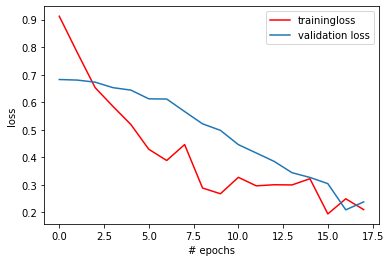

In [26]:
from matplotlib import pyplot as plt
plt.plot(covid.history['loss'],'r',label='trainingloss')
plt.plot(covid.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

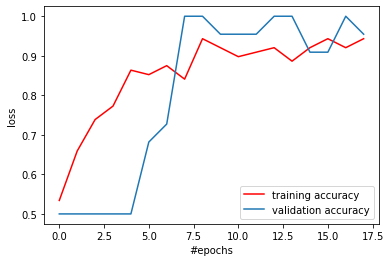

In [27]:
plt.plot(covid.history['accuracy'],'r',label='training accuracy')
plt.plot(covid.history['val_accuracy'],label='validation accuracy')
plt.xlabel('#epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [35]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import sys
from PIL import Image

successive_outputs = [layer.output for layer in model.layers[1:]]

visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

img  = cv2.imread('C:/Users/Lenovo/Desktop/random image.jpeg')
img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      # arrange format as per deep learning libraries
img  = cv2.resize(img,(250,250))                 # resize as per model

x = img_to_array(img)  # Numpy array with shape (250, 250, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 250, 250, 3)

# Rescale by 1/255 
x /= 255

# Make prediction
successive_feature_maps = model.predict(x)
print(successive_feature_maps)

for index, probability in enumerate(successive_feature_maps):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

error: ignored